<a href="https://colab.research.google.com/github/tanyavijj/Tanya-project/blob/main/SRGAN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os

# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define paths
zip_path = "/content/drive/MyDrive/archive (5).zip"
extract_dir = "/content/dataset"

# Extract zip file if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
# Define HR image folders
train_dir = os.path.join(extract_dir, "DIV2K_train_HR")
val_dir = os.path.join(extract_dir, "DIV2K_valid_HR")


In [3]:
# ========== STEP 2: Import Libraries ==========
import numpy as np
import pandas as pd
import glob
import itertools
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg19
from PIL import Image

In [4]:
# ========== STEP 3: Set Hyperparameters ==========
load_pretrained_models = True
n_epochs = 2
batch_size = 4
lr = 0.0001
b1 = 0.5
b2 = 0.999
decay_epoch = 100
hr_shape = (128, 128)

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


In [5]:
# ========== STEP 4: Define Dataset ==========
class SRDataset(Dataset):
    def __init__(self, directory, hr_shape):
        self.files = sorted(glob.glob(os.path.join(directory, '*')))
        hr_height, hr_width = hr_shape

        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_width), Image.BICUBIC),
            transforms.ToTensor(),
        ])

        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_width // 4), Image.BICUBIC),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert("RGB")
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        return {"lr": lr_img, "hr": hr_img}

    def __len__(self):
        return len(self.files)

In [6]:
# ========== STEP 5: Define VGG Feature Extractor ==========
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

In [7]:
# # ========== STEP 6: Generator Network ==========
# class ResidualBlock(nn.Module):
#     def __init__(self, in_features):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_features, in_features, 3, 1, 1),
#             nn.BatchNorm2d(in_features),
#             nn.PReLU(),
#             nn.Conv2d(in_features, in_features, 3, 1, 1),
#             nn.BatchNorm2d(in_features)
#         )

#     def forward(self, x):
#         return x + self.block(x)

# class GeneratorResNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
#         super(GeneratorResNet, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, 9, 1, 4),
#             nn.PReLU()
#         )

#         res_blocks = [ResidualBlock(64) for _ in range(n_residual_blocks)]
#         self.res_blocks = nn.Sequential(*res_blocks)

#         self.mid_block = nn.Sequential(
#             nn.Conv2d(64, 64, 3, 1, 1),
#             nn.BatchNorm2d(64)
#         )

#         self.upsample = nn.Sequential(
#             nn.Conv2d(64, 256, 3, 1, 1),
#             nn.PixelShuffle(2),
#             nn.PReLU(),
#             nn.Conv2d(64, 256, 3, 1, 1),
#             nn.PixelShuffle(2),
#             nn.PReLU()
#         )

#         self.output = nn.Conv2d(64, out_channels, 9, 1, 4)

#     def forward(self, x):
#         out1 = self.conv1(x)
#         out = self.res_blocks(out1)
#         out = self.mid_block(out)
#         out = out + out1
#         out = self.upsample(out)
#         return self.output(out)

In [13]:
# ========== STEP 6: Dataset Class ==========
class SRDataset(Dataset):
    def __init__(self, directory, hr_shape):
        # Recursively collect only image files
        self.files = [f for f in glob.glob(os.path.join(directory, '**'), recursive=True)
                      if os.path.isfile(f) and f.lower().endswith(('png', 'jpg', 'jpeg'))]
        hr_height, hr_width = hr_shape

        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_width), Image.BICUBIC),
            transforms.ToTensor(),
        ])

        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_width // 4), Image.BICUBIC),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert("RGB")
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        return {"lr": lr_img, "hr": hr_img}

    def __len__(self):
        return len(self.files)

In [14]:
# ========== STEP 7: Discriminator Network ==========
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        in_channels, in_height, in_width = input_shape
        patch_h, patch_w = in_height // 2**4, in_width // 2**4
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = [nn.Conv2d(in_filters, out_filters, 3, 1, 1)]
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers += [nn.LeakyReLU(0.2), nn.Conv2d(out_filters, out_filters, 3, 2, 1), nn.BatchNorm2d(out_filters), nn.LeakyReLU(0.2)]
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, True),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Flatten(),
            nn.Linear(512 * patch_h * patch_w, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1)
        )

    def forward(self, img):
        return self.model(img)

In [15]:
# # ========== STEP 8: Visualize Generator Output ==========
# import matplotlib.pyplot as plt

# def show_sample_output(generator, dataset, device):
#     generator.eval()
#     sample = None

#     # Try to get the first valid image (not a directory)
#     for i in range(len(dataset)):
#         try:
#             sample = dataset[i]
#             break
#         except IsADirectoryError:
#             continue

#     if sample is None:
#         print("No valid image found in dataset.")
#         return

#     lr_image = sample['lr'].unsqueeze(0).to(device)
#     hr_image = sample['hr']

#     with torch.no_grad():
#         sr_image = generator(lr_image).squeeze(0).cpu()

#     def denormalize(tensor):
#         return tensor.clamp(0, 1).permute(1, 2, 0).numpy()

#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     axs[0].imshow(denormalize(sample['lr']))
#     axs[0].set_title('Low-Resolution Input')
#     axs[1].imshow(denormalize(sr_image))
#     axs[1].set_title('Super-Resolved Output')
#     axs[2].imshow(denormalize(hr_image))
#     axs[2].set_title('High-Resolution Ground Truth')
#     for ax in axs:
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [16]:
# ========== STEP 8: Visualize Generator Output ==========
import matplotlib.pyplot as plt

def show_sample_output(generator, dataset, device):
    generator.eval()
    sample = None

    for i in range(len(dataset)):
        try:
            sample = dataset[i]
            break
        except Exception as e:
            continue

    if sample is None:
        print("No valid image found in dataset.")
        return

    lr_image = sample['lr'].unsqueeze(0).to(device)
    hr_image = sample['hr']

    with torch.no_grad():
        sr_image = generator(lr_image).squeeze(0).cpu()

    def denormalize(tensor):
        return tensor.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(denormalize(sample['lr']))
    axs[0].set_title('Low-Resolution Input')
    axs[1].imshow(denormalize(sr_image))
    axs[1].set_title('Super-Resolved Output')
    axs[2].imshow(denormalize(hr_image))
    axs[2].set_title('High-Resolution Ground Truth')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


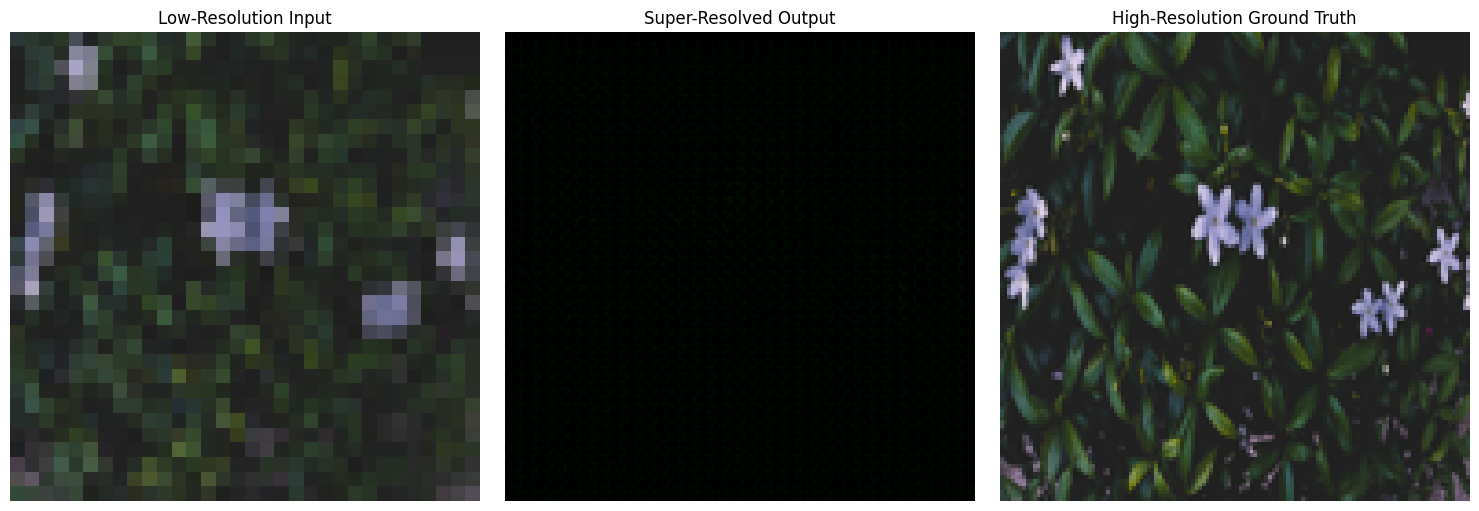

In [17]:
# ========== STEP 9: Run Visualization ==========
# Initialize generator and dataset
generator = GeneratorResNet().to(device)
dataset = SRDataset(val_dir, hr_shape)

# Load pretrained weights if available
# Example: generator.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/generator.pth"))

# Show output
show_sample_output(generator, dataset, device)